In [1]:
import numpy as np
import random

In [2]:
#
class Graph():
  def __init__(self, count_nodes, dist, phero_lv = None):
    self.count_nodes = count_nodes
    self.dist = dist
    if phero_lv:
      self.phero = np.full_like(dist, phero_lv).astype('float64')
    else:
      self.phero = np.full_like(dist, self.dist.mean() * 10).astype('float64')

  def __str__(self):
    return f'node: {str(self.nodes)}, distance: {self.dist}, phero_weight: {self.phero}'

In [3]:
cities = []
with open("TSP51.txt", "r") as f:
    for line in f:
        node_city_val = line.split()
        cities.append([float(node_city_val[1]), float(node_city_val[2])])

num_cities = len(cities)
distance_matrix = np.zeros((num_cities, num_cities), dtype=np.float64)

for i in range(num_cities):
    for j in range(i + 1, num_cities):
        city1 = cities[i]
        city2 = cities[j]
        dist = np.sqrt((city2[0] - city1[0])**2 + (city2[1] - city1[1])**2)
        distance_matrix[i][j] = dist
        distance_matrix[j][i] = dist

print("Distance Matrix created with shape:", distance_matrix.shape)

Distance Matrix created with shape: (51, 51)


## **I. ACO**

In [4]:
import matplotlib.pyplot as plt

class ACO_Solver:
    def __init__(self, graph, alpha=0.9, beta=1.5, iters=10, ants_per_iter=10, const_q=10, const_degrade=0.9):
        self.graph = graph
        self.alpha = alpha
        self.beta = beta
        self.iters = iters
        self.ants_per_iter = ants_per_iter
        self.const_q = const_q
        self.const_degrade = const_degrade

    def _len_cycle(self, cycle):
        length = 0
        i = 0
        while i < len(cycle) - 1:
            length += self.graph.dist[cycle[i]][cycle[i+1]]
            i+=1
        length += self.graph.dist[cycle[i]][cycle[0]]
        return length

    def _travel_graph(self, start_node = 0):
        cycle = [start_node]
        count = self.graph.count_nodes
        pass_node = np.asarray([0 for i in range(count)])
        pass_node[start_node] = 1
        curr_node = start_node
        total = 0
        while len(cycle) < count:
            edge_val = []
            near_node = []
            for node in range(count):
                if pass_node[node] == 0:
                    phero_lv = max(self.graph.phero[curr_node][node], 1e-9)
                    weight = (phero_lv**self.alpha ) / (self.graph.dist[curr_node][node]**self.beta)
                    edge_val.append(weight)
                    near_node.append(node)

            if not near_node:
                break

            next_node = random.choices(near_node, weights = edge_val)[0]
            pass_node[next_node] = 1
            cycle.append(next_node)
            curr_node = next_node

        total_len = self._len_cycle(cycle)
        return cycle, total_len

    def solve(self):
        curr_best = None
        curr_best_len = float("inf")
        old_best = None
        limit = 0
        patience = 100
        max_patience = 150 # Added patience for early stopping

        best_lengths = []
        iter_times = []

        for iter in range(self.iters):
            start_time = time.time()
            if (iter < 10 or iter % 10 == 0):
              print('-' * 30)
              print("Iteration: ", iter + 1,"/", self.iters)

            cycle_ants = []
            for i in range(self.ants_per_iter):
                res = self._travel_graph(random.randint(0, self.graph.count_nodes -1))
                cycle_ants.append(res)

            cycle_ants.sort(key = lambda x: x[1])

            # Save the current best length before updating to check for improvement
            old_best_len_this_iter = curr_best_len

            if curr_best:
                cycle_ants.append((curr_best, curr_best_len))
                old_best = curr_best_len

            for cycle, total_len in cycle_ants:
                if total_len < curr_best_len:
                    curr_best = cycle
                    curr_best_len = total_len

                plus = self.const_q/total_len
                i = 0
                while i < len(cycle) - 1:
                    self.graph.phero[cycle[i]][cycle[i+1]]+= plus
                    i+=1
                self.graph.phero[cycle[i]][cycle[0]] += plus
                self.graph.phero *= self.const_degrade

            # Check for improvement and update patience limit
            if curr_best_len < old_best_len_this_iter:
                limit = 0 # Reset limit if there's an improvement
            else:
                limit += 1 # Increment limit if no improvement

            if limit >= patience:
                self.graph.phero += self.graph.phero.mean()
            if limit >= max_patience:
                print("Early stopping due to no improvement in", max_patience, "iterations.")
                break

            end_time = time.time()
            best_lengths.append(curr_best_len)
            iter_times.append(end_time - start_time)
            if (iter < 10 or iter % 10 == 0):
              print("Best current solution: ",curr_best_len)

        return curr_best, curr_best_len, best_lengths, iter_times

    def test_and_plot(self, graph):
        solution, best_len, best_lengths, iter_times = self.solve()
        print("Best solution:", solution)
        print("Best length:", best_len)

        # Plot best length after each iteration
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(best_lengths) + 1), best_lengths)
        plt.xlabel("Iteration")
        plt.ylabel("Best Length")
        plt.title("Best Tour Length After Each Iteration")
        plt.grid(True)
        plt.show()

        # Plot time taken for each iteration
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(iter_times) + 1), iter_times)
        plt.xlabel("Iteration")
        plt.ylabel("Time (s)")
        plt.title("Time Taken for Each Iteration")
        plt.grid(True)
        plt.show()

In [5]:
import time
def test_aco_refactored():
    dist_list = [(0, 1, 3.1623), (0, 2, 4.1231), (0, 3, 5.8310), (0, 4, 4.2426), \
             (0, 5, 5.3852), (0, 6, 4.0000), (0, 7, 2.2361), (1, 2, 1.0000), \
             (1, 3, 2.8284), (1, 4, 2.0000), (1, 5, 4.1231), (1, 6, 4.2426), \
             (1, 7, 2.2361), (2, 3, 2.2361), (2, 4, 2.2361), (2, 5, 4.4721), \
             (2, 6, 5.0000), (2, 7, 3.1623), (3, 4, 2.0000), (3, 5, 3.6056), \
             (3, 6, 5.0990), (3, 7, 4.1231), (4, 5, 2.2361), (4, 6, 3.1623), \
             (4, 7, 2.2361), (5, 6, 2.2361), (5, 7, 3.1623), (6, 7, 2.2361)]

    bigger_graph = Graph(8, np.zeros((8,8)).astype('float64') )

    for i, j, dist in dist_list:
        bigger_graph.dist[i][j] = dist
        bigger_graph.dist[j][i] = dist

    aco_solver = ACO_Solver(bigger_graph, iters=300)
    solution, best_len, best_lengths, iter_times = aco_solver.solve() # Use solve method
    print("Best solution:", solution)
    print("Best length:", best_len)

    # Plot best length after each iteration
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(best_lengths) + 1), best_lengths)
    plt.xlabel("Iteration")
    plt.ylabel("Best Length")
    plt.title("Best Tour Length After Each Iteration (Refactored ACO) - Bigger Graph")
    plt.grid(True)
    plt.show()

    # Plot time taken for each iteration
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(iter_times) + 1), iter_times)
    plt.xlabel("Iteration")
    plt.ylabel("Time (s)")
    plt.title("Time Taken for Each Iteration (Refactored ACO) - Bigger Graph")
    plt.grid(True)
    plt.show()

# Modify the main comparison code to use ACO_Solver
tsp_graph_aco_solver = ACO_Solver(Graph(num_cities, distance_matrix), iters=500)
best_route_aco, travelled_aco, best_lengths_aco, iter_times_aco = tsp_graph_aco_solver.solve()
print("ACO - Best route found:", best_route_aco)
print("ACO - Travelled distance:", travelled_aco)


------------------------------
Iteration:  1 / 500
Best current solution:  1110.3028279391724
------------------------------
Iteration:  2 / 500
Best current solution:  938.5825534049495
------------------------------
Iteration:  3 / 500
Best current solution:  938.5825534049495
------------------------------
Iteration:  4 / 500
Best current solution:  938.5825534049495
------------------------------
Iteration:  5 / 500
Best current solution:  938.5825534049495
------------------------------
Iteration:  6 / 500
Best current solution:  938.5825534049495
------------------------------
Iteration:  7 / 500
Best current solution:  912.3155991987614
------------------------------
Iteration:  8 / 500
Best current solution:  912.3155991987614
------------------------------
Iteration:  9 / 500
Best current solution:  912.3155991987614
------------------------------
Iteration:  10 / 500
Best current solution:  892.4357001586936
------------------------------
Iteration:  11 / 500
Best current sol

## **II. PSO**

In [8]:
from typing import List, Tuple, Union
class Agent:
    def __init__(self, agent_id: int = 0, location_count: int = 0):
        self.agent_id = agent_id
        self.location_count = location_count

        # Khởi tạo hành trình (bắt đầu và kết thúc tại 0)
        permuted = np.random.permutation(np.arange(1, location_count + 1))
        self.route = np.array([0, *permuted.tolist(), 0], dtype=int)

        # swaps là danh sách các cặp hoán đổi (i, j) hoặc dấu hiệu 'RESHUFFLE'
        self.swaps: Union[List[Tuple[int,int]], str] = []

        # Lưu trữ cá nhân tốt nhất
        self.personal_best_route = self.route.copy()
        self.personal_best_score = float('inf')

    def compute_score(self, distance_matrix: np.ndarray) -> float:

        #Tính tổng khoảng cách của route hiện tại bằng zip trên cặp điểm liên tiếp.
        #Nếu tốt hơn personal best thì cập nhật.
        total = 0.0
        # zip qua các cặp liên tiếp (prev, curr)
        for prev_loc, curr_loc in zip(self.route[:-1], self.route[1:]):
            total += float(distance_matrix[prev_loc, curr_loc])

        # Cập nhật personal best nếu cần
        if total < self.personal_best_score:
            self.personal_best_score = total
            self.personal_best_route = self.route.copy()

        return total

    def compute_swaps(self,
                      global_best_score: float,
                      global_best_route: np.ndarray,
                      w: float = 0.3,
                      c1: float = 0.6,
                      c2: float = 1.0):
        #Tạo danh sách hoán đổi mới dựa trên ảnh hưởng cá nhân và toàn cục.
        # Nếu chưa có best toàn cục hoặc muốn xáo trộn ngẫu nhiên -> đặt cờ
        if global_best_score == float('inf') or random.random() > 0.85:
            self.swaps = 'RESHUFFLE'
            return

        proposed_swaps: List[Tuple[int,int]] = []
        used_positions = set()

        # Duyệt các chỉ số của địa điểm trong route (bỏ vị trí 0 ở hai đầu)
        indices = list(range(1, self.location_count + 1))
        # Thay đổi thứ tự xử lý để khác so với vòng for cố định
        random.shuffle(indices)

        for pos in indices:
            # inertia: giữ nguyên (không hoán đổi) với xác suất inertia
            if random.random() < w:
                used_positions.add(pos)
                continue

            r = random.random()
            # ưu tiên ảnh hưởng cá nhân (cognitive), sau đó ảnh hưởng toàn cục (social)
            if r < c1:
                # tìm vị trí của location hiện tại trong personal best route
                loc = self.route[pos]
                found = np.flatnonzero(self.personal_best_route == loc)
                if found.size == 0:
                    continue
                swap_pos = int(found[0])
                if pos not in used_positions and swap_pos not in used_positions:
                    proposed_swaps.append((pos, swap_pos))
                    used_positions.update({pos, swap_pos})

            elif r < c1 + c2:
                # tìm vị trí của location hiện tại trong global best route
                loc = self.route[pos]
                found = np.flatnonzero(global_best_route == loc)
                if found.size == 0:
                    continue
                swap_pos = int(found[0])
                if pos not in used_positions and swap_pos not in used_positions:
                    proposed_swaps.append((pos, swap_pos))
                    used_positions.update({pos, swap_pos})

            # else: không làm gì (bỏ qua), tiếp vị trí tiếp theo

        self.swaps = proposed_swaps

    def apply_swaps(self):
        if self.swaps == 'RESHUFFLE':
            # lấy hai chỉ số ngẫu nhiên (không lấy điểm 0 ở hai đầu)
            i, j = random.sample(range(1, self.location_count + 1), 2)
            self.route[i], self.route[j] = self.route[j], self.route[i]
        else:
            # thực hiện từng hoán đổi (i, j)
            for a, b in self.swaps:
                # đảm bảo là indices hợp lệ trong mảng route
                if 0 <= a < len(self.route) and 0 <= b < len(self.route):
                    self.route[a], self.route[b] = self.route[b], self.route[a]

In [22]:


class PSO_Solver:
    def __init__(self, graph, max_iters: int = 300):
        self.graph = graph
        self.max_iters = max_iters
        # số địa điểm (không tính node 0 là start/end)
        self.num_locations = graph.count_nodes - 1
        # số particle dựa trên số node như trước
        self.num_particles = ((4 * (graph.count_nodes - 1)) ** 2)

    def solve(self):
        # Ma trận khoảng cách
        distance_matrix = self.graph.dist

        print(f"Number of agents (particles): {self.num_particles}")
        # Khởi tạo agents
        agents = [Agent(agent_id + 1, self.num_locations) for agent_id in range(self.num_particles)]

        epsilon = []
        # theo dõi best toàn cục
        global_best_route = None
        global_best_score = float('inf')

        best_score_history = []
        iter_times = []

        for iter in range(self.max_iters):
            start_time = time.time()

            # Đánh giá fitness / score cho từng agent
            for ag in agents:
                score = ag.compute_score(distance_matrix)
                # compute_score đã cập nhật personal best bên trong
                # cập nhật global best nếu cần
                if score < global_best_score:
                    global_best_score = score
                    global_best_route = ag.route.copy()

            epsilon.append(global_best_score)

            # Cập nhật "vận tốc" (swaps) và áp dụng chúng
            for ag in agents:
                ag.compute_swaps(global_best_score, global_best_route)
                ag.apply_swaps()

            end_time = time.time()
            best_score_history.append(global_best_score)
            iter_times.append(end_time - start_time)

            if (iter < 10 or iter % 10 == 0):
                print('-' * 30)
                print(f'Iteration: {iter + 1}')
                print(f'global_best_score: {global_best_score}')

            # Kiểm tra hội tụ (early stopping)
            if len(epsilon) >= 50:
                if len(set(epsilon[-25:])) == 1:
                    print(f"Early stopping at iteration {iter + 1} due to convergence.")
                    break

        return global_best_route, global_best_score, best_score_history, iter_times

    def test_and_plot(self):
        solution, best_len, best_lengths, iter_times = self.solve()
        print("Best route:", solution)
        print("Best length:", best_len)

        # Plot best length sau mỗi iteration
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(best_lengths) + 1), best_lengths)
        plt.xlabel("Iteration")
        plt.ylabel("Best Fitness (Travelled Distance)")
        plt.title("Best Fitness After Each Iteration (Refactored PSO)")
        plt.grid(True)
        plt.show()

        # Plot thời gian mỗi iteration
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(iter_times) + 1), iter_times)
        plt.xlabel("Iteration")
        plt.ylabel("Time (s)")
        plt.title("Time Taken for Each Iteration (Refactored PSO)")
        plt.grid(True)
        plt.show()


Number of agents (particles): 784
------------------------------
Iteration: 1
global_best_score: 17.3428
------------------------------
Iteration: 2
global_best_score: 17.3428
------------------------------
Iteration: 3
global_best_score: 17.3428
------------------------------
Iteration: 4
global_best_score: 17.3428
------------------------------
Iteration: 5
global_best_score: 17.3428
------------------------------
Iteration: 6
global_best_score: 17.3428
------------------------------
Iteration: 7
global_best_score: 17.3428
------------------------------
Iteration: 8
global_best_score: 17.3428
------------------------------
Iteration: 9
global_best_score: 17.3428
------------------------------
Iteration: 10
global_best_score: 17.3428
------------------------------
Iteration: 11
global_best_score: 17.3428
------------------------------
Iteration: 21
global_best_score: 17.3428
------------------------------
Iteration: 31
global_best_score: 17.3428
------------------------------
Iteratio

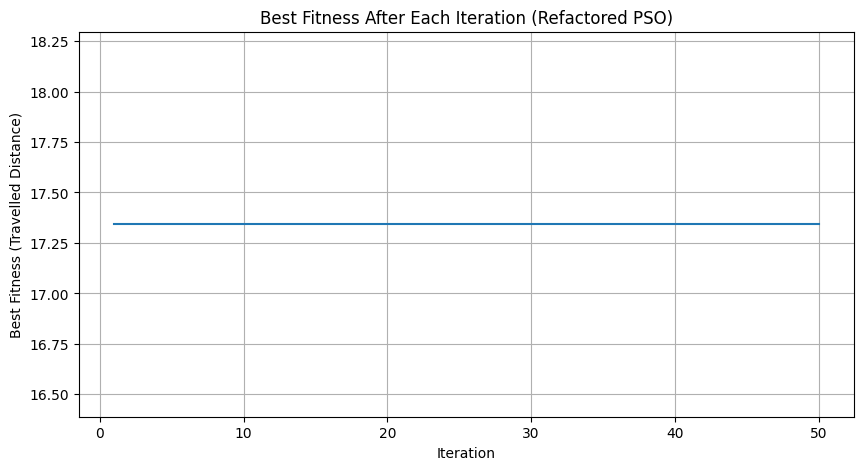

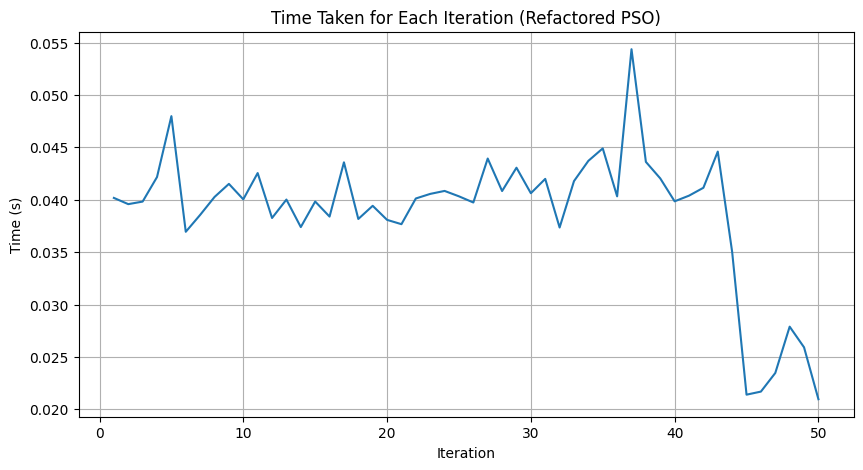

In [23]:
dist_list = [(0, 1, 3.1623), (0, 2, 4.1231), (0, 3, 5.8310), (0, 4, 4.2426), \
             (0, 5, 5.3852), (0, 6, 4.0000), (0, 7, 2.2361), (1, 2, 1.0000), \
             (1, 3, 2.8284), (1, 4, 2.0000), (1, 5, 4.1231), (1, 6, 4.2426), \
             (1, 7, 2.2361), (2, 3, 2.2361), (2, 4, 2.2361), (2, 5, 4.4721), \
             (2, 6, 5.0000), (2, 7, 3.1623), (3, 4, 2.0000), (3, 5, 3.6056), \
             (3, 6, 5.0990), (3, 7, 4.1231), (4, 5, 2.2361), (4, 6, 3.1623), \
             (4, 7, 2.2361), (5, 6, 2.2361), (5, 7, 3.1623), (6, 7, 2.2361)]

bigger_graph = Graph(8, np.zeros((8,8)).astype('float64') )
for i, j, dist in dist_list:
  bigger_graph.dist[i][j] = dist
  bigger_graph.dist[j][i] = dist
PSO = PSO_Solver(bigger_graph)
PSO.test_and_plot()

## **III. Genetic Algorithm**

In [33]:
import random
import math
import matplotlib.pyplot as plt
import time
from typing import List, Tuple, Optional

class GA_solver:
    def __init__(
        self,
        filepath: Optional[str] = "TSP51.txt",
        cities: Optional[List[List]] = None,
        population_size: int = 1000,
        mutation_rate: float = 0.01,
        crossover_rate: float = 0.8,
        tournament_size: int = 5,
        elitism: int = 2,
        max_generations: int = 200,
        target: float = float("inf"),
    ):
        # Tham số GA
        self.filepath = filepath
        self.cities = cities if cities is not None else self._load_cities(filepath)
        self.N = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size
        self.elitism = elitism
        self.max_generations = max_generations
        self.target = target

        # Lưu population dạng list of [distance, route]
        self.population: List[Tuple[float, List]] = []

    def _load_cities(self, filepath: str) -> List[List]:
        #Đọc file TSP (mỗi dòng: id x y) -> trả về list các thành phố [id, x, y]
        cities = []
        if filepath is None:
            return cities
        with open(filepath, "r") as f:
            for line in f:
                parts = line.split()
                if len(parts) >= 3:
                    cities.append([parts[0], float(parts[1]), float(parts[2])])
        return cities

    @staticmethod
    def calc_distance(route: List[List]) -> float:
        if not route:
            return 0.0
        total = 0.0
        for i in range(len(route) - 1):
            ax, ay = route[i][1], route[i][2]
            bx, by = route[i + 1][1], route[i + 1][2]
            total += math.hypot(bx - ax, by - ay)
        # cộng đoạn cuối -> đầu
        ax, ay = route[-1][1], route[-1][2]
        bx, by = route[0][1], route[0][2]
        total += math.hypot(bx - ax, by - ay)
        return total

    # Population init & evaluation
    def initialize_population(self):
        self.population = []
        for _ in range(self.N):
            route = self.cities.copy()
            random.shuffle(route)
            dist = self.calc_distance(route)
            self.population.append([dist, route])

    # Selection
    def tournament_selection(self) -> List:
        candidates = random.sample(self.population, k=self.tournament_size)
        best = min(candidates, key=lambda x: x[0])
        return best[1].copy()

    # Crossover
    def order_crossover(self, parent1: List, parent2: List) -> Tuple[List, List]:
        size = len(parent1)

        a, b = sorted(random.sample(range(size), 2))
        def make_child(pA, pB):
            child = [None] * size
            # copy middle segment
            child[a : b + 1] = pA[a : b + 1]
            # fill rest from pB in order
            ptr = (b + 1) % size
            for gene in pB[b+1:] + pB[:b+1]:
                if gene not in child:
                    # find next empty pos starting at ptr
                    while child[ptr] is not None:
                        ptr = (ptr + 1) % size
                    child[ptr] = gene
                    ptr = (ptr + 1) % size
            return child

        child1 = make_child(parent1, parent2)
        child2 = make_child(parent2, parent1)
        return child1, child2

    #Mutation
    def swap_mutation(self, route: List) -> List:
        #Swap mutation: chọn hai vị trí và đổi chỗ (phổ biến cho permutation).
        size = len(route)
        i, j = random.sample(range(size), 2)
        route[i], route[j] = route[j], route[i]
        return route

    #One evolution step
    def evolve_one_generation(self):
        # sắp xếp population theo fitness (distance) tăng dần (mức tốt nhất đứng đầu)
        self.population.sort(key=lambda x: x[0])
        new_pop = []

        # Elitism: giữ lại 'elitism' cá thể tốt nhất (prevents losing best solutions)
        for i in range(min(self.elitism, len(self.population))):
            # copy để tránh tham chiếu chung
            best_route = self.population[i][1].copy()
            new_pop.append([self.calc_distance(best_route), best_route])

        # Sinh phần còn lại
        while len(new_pop) < self.N:
            # Selection: tournament selection (lấy hai cha mẹ)
            parent1 = self.tournament_selection()
            parent2 = self.tournament_selection()

            # Crossover (recombination)
            if random.random() < self.crossover_rate:
                child1, child2 = self.order_crossover(parent1, parent2)
            else:
                # nếu không crossover thì sao chép cha mẹ (có thể vẫn mutate)
                child1, child2 = parent1.copy(), parent2.copy()

            # Mutation
            if random.random() < self.mutation_rate:
                child1 = self.swap_mutation(child1)
            if random.random() < self.mutation_rate:
                child2 = self.swap_mutation(child2)

            # Thêm vào population mới
            new_pop.append([self.calc_distance(child1), child1])
            if len(new_pop) < self.N:
                new_pop.append([self.calc_distance(child2), child2])

        self.population = new_pop

    # Run GA
    def run(self):
        if not self.population:
            self.initialize_population()

        gen = 0
        best_solution = min(self.population, key=lambda x: x[0])
        best_solution_history = []
        iter_times = []

        while gen < self.max_generations:
            start_time = time.time()
            self.evolve_one_generation()
            gen += 1

            # cập nhật best
            curr_best = min(self.population, key=lambda x: x[0])
            if curr_best[0] < best_solution[0]:
                best_solution = curr_best

            best_solution_history.append(best_solution[0])

            if gen < 10 or gen % 10 == 0:
                print(f"Gen {gen}: best distance = {best_solution[0]:.6f}")

            if best_solution[0] <= self.target:
                print(f"Target reached at generation {gen}.")
                break
            end_time = time.time()
            iter_times.append(end_time - start_time)

        end_time = time.time()
        total_time = sum(iter_times)
        return best_solution[1], best_solution[0], best_solution_history, total_time, iter_times

    # Visualization
    def draw_map(self, answer: List):
        route = answer

        xs = [c[1] for c in self.cities]
        ys = [c[2] for c in self.cities]
        plt.figure(figsize=(8, 6))
        plt.scatter(xs, ys, c="red")
        for city in self.cities:
            plt.annotate(city[0], (city[1], city[2]))

        for i in range(len(route) - 1):
            a = route[i]
            b = route[i + 1]
            plt.plot([a[1], b[1]], [a[2], b[2]], color="gray")

        a = route[-1]
        b = route[0]
        plt.plot([a[1], b[1]], [a[2], b[2]], color="gray")
        plt.title(f"TSP route (distance = {self.calc_distance(answer):.3f})")
        plt.show()

## Compare results



Gen 1: best distance = 1316.861083
Gen 2: best distance = 1239.590958
Gen 3: best distance = 1164.571715
Gen 4: best distance = 1117.877244
Gen 5: best distance = 1117.877244
Gen 6: best distance = 1087.616308
Gen 7: best distance = 1023.866023
Gen 8: best distance = 979.192699
Gen 9: best distance = 931.634030
Gen 10: best distance = 890.338609
Gen 20: best distance = 737.597016
Gen 30: best distance = 625.530471
Gen 40: best distance = 566.642038
Gen 50: best distance = 525.396102
Gen 60: best distance = 510.648763
Gen 70: best distance = 487.715067
Gen 80: best distance = 461.237729
Gen 90: best distance = 457.019930
Gen 100: best distance = 453.645499
Gen 110: best distance = 453.645499
Gen 120: best distance = 453.645499
Gen 130: best distance = 453.645499
Gen 140: best distance = 453.645499
Gen 150: best distance = 453.645499
Gen 160: best distance = 453.645499
Gen 170: best distance = 453.645499
Gen 180: best distance = 453.645499
Gen 190: best distance = 453.645499
Gen 200: bes

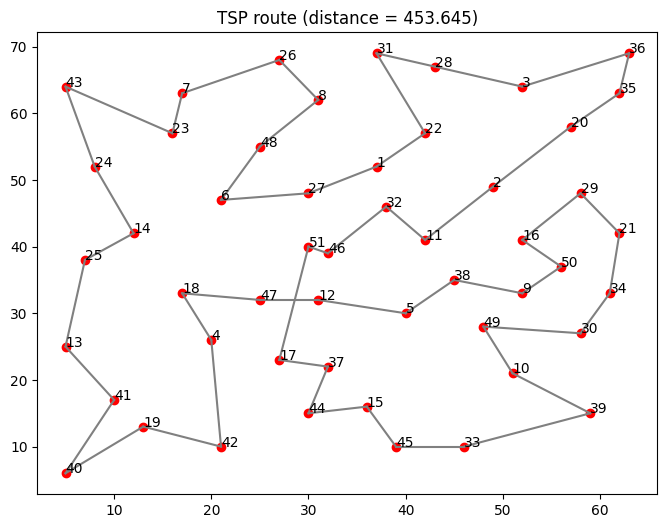

[0.2676424980163574, 0.2909812927246094, 0.2650322914123535, 0.26278138160705566, 0.2704923152923584, 0.26988911628723145, 0.2568330764770508, 0.26152634620666504, 0.27673959732055664, 0.1754612922668457, 0.1577458381652832, 0.14853453636169434, 0.1472322940826416, 0.14777016639709473, 0.14351320266723633, 0.1781158447265625, 0.15040016174316406, 0.15389060974121094, 0.30323147773742676, 0.15629863739013672, 0.1705944538116455, 0.24024009704589844, 0.1716470718383789, 0.14563846588134766, 0.1481788158416748, 0.14748573303222656, 0.15230917930603027, 0.16649270057678223, 0.13755583763122559, 0.14899849891662598, 0.14186525344848633, 0.14653301239013672, 0.14703774452209473, 0.1509993076324463, 0.16423869132995605, 0.13987112045288086, 0.14728093147277832, 0.14515042304992676, 0.14712023735046387, 0.1565256118774414, 0.15516138076782227, 0.16491246223449707, 0.14843106269836426, 0.14362621307373047, 0.2673048973083496, 0.1500840187072754, 0.1496870517730713, 0.1591472625732422, 0.1456604

In [34]:
GA_tsp = GA_solver("TSP51.txt", target=450, population_size=2000)
best_route_ga, travelled_ga, best_lengths_ga, total_time_ga, iter_times_ga = GA_tsp.run()
GA_tsp.draw_map(best_route_ga)
print(iter_times_ga)


Compare the performance of ACO, PSO, and Genetic Algorithm on the TSP problem using the data from "TSP51.txt". Create a distance matrix from the data and apply ACO and PSO to it. Apply the Genetic Algorithm directly to the city coordinates as previously implemented. Visualize the shortest tour found and the execution time for each algorithm.

## Load and process data



In [ ]:
cities = []
with open("TSP51.txt", "r") as f:
    for line in f:
        node_city_val = line.split()
        cities.append([float(node_city_val[1]), float(node_city_val[2])])

num_cities = len(cities)
distance_matrix = np.zeros((num_cities, num_cities), dtype=np.float64)

for i in range(num_cities):
    for j in range(i + 1, num_cities):
        city1 = cities[i]
        city2 = cities[j]
        dist = np.sqrt((city2[0] - city1[0])**2 + (city2[1] - city1[1])**2)
        distance_matrix[i][j] = dist
        distance_matrix[j][i] = dist

print("Distance Matrix created with shape:", distance_matrix.shape)

Distance Matrix created with shape: (51, 51)


## Run aco



In [15]:
tsp_graph_aco = Graph(num_cities, distance_matrix)
best_route_aco, travelled_aco, best_lengths_aco, iter_times_aco = ACO_Solver(tsp_graph_aco, iters=500).solve()
print("ACO - Best route found:", best_route_aco)
print("ACO - Travelled distance:", travelled_aco)

Iteration:  1 / 500
984.9203806935396
Iteration:  2 / 500
984.9203806935396
Iteration:  3 / 500
984.9203806935396
Iteration:  4 / 500
937.9934481264032
Iteration:  5 / 500
937.9934481264032
Iteration:  6 / 500
937.9934481264032
Iteration:  7 / 500
937.9934481264032
Iteration:  8 / 500
937.9934481264032
Iteration:  9 / 500
937.9934481264032
Iteration:  10 / 500
937.9934481264032
Iteration:  11 / 500
847.2745717682077
Iteration:  12 / 500
744.1443358546197
Iteration:  13 / 500
715.6116764852308
Iteration:  14 / 500
649.5398930618331
Iteration:  15 / 500
594.3582933114467
Iteration:  16 / 500
594.3582933114467
Iteration:  17 / 500
594.3582933114467
Iteration:  18 / 500
592.8171415616841
Iteration:  19 / 500
552.5359332550382
Iteration:  20 / 500
552.5359332550382
Iteration:  21 / 500
552.5359332550382
Iteration:  22 / 500
552.5359332550382
Iteration:  23 / 500
552.5359332550382
Iteration:  24 / 500
552.5359332550382
Iteration:  25 / 500
552.5359332550382
Iteration:  26 / 500
552.535933255

In [24]:
tsp_graph_pso = Graph(num_cities, distance_matrix)
best_route_pso, travelled_pso, best_fitness_history_pso, iter_times_pso = PSO_Solver(tsp_graph_pso, max_iters=200).solve()
print("PSO - Best route found:", best_route_pso)
print("PSO - Travelled distance:", travelled_pso)

Number of agents (particles): 40000
------------------------------
Iteration: 1
global_best_score: 1282.940621329344
------------------------------
Iteration: 2
global_best_score: 1269.4176796619827
------------------------------
Iteration: 3
global_best_score: 1241.8385460219524
------------------------------
Iteration: 4
global_best_score: 1241.8385460219524
------------------------------
Iteration: 5
global_best_score: 1200.6683947383083
------------------------------
Iteration: 6
global_best_score: 1200.6683947383083
------------------------------
Iteration: 7
global_best_score: 1179.3229662439335
------------------------------
Iteration: 8
global_best_score: 1143.4877870219611
------------------------------
Iteration: 9
global_best_score: 1073.3145839894669
------------------------------
Iteration: 10
global_best_score: 1073.3145839894669
------------------------------
Iteration: 11
global_best_score: 1073.3145839894669
------------------------------
Iteration: 21
global_best_scor

Gen 1: best distance = 1307.322037
Gen 2: best distance = 1239.433502
Gen 3: best distance = 1183.527440
Gen 4: best distance = 1097.626239
Gen 5: best distance = 1057.898999
Gen 6: best distance = 1002.543844
Gen 7: best distance = 1002.543844
Gen 8: best distance = 1002.543844
Gen 9: best distance = 988.544662
Gen 10: best distance = 949.313181
Gen 20: best distance = 794.359652
Gen 30: best distance = 650.928043
Gen 40: best distance = 548.917655
Gen 50: best distance = 507.383506
Gen 60: best distance = 488.150807
Gen 70: best distance = 472.442638
Gen 80: best distance = 467.712665
Gen 90: best distance = 467.712665
Gen 100: best distance = 466.735957
Gen 110: best distance = 466.735957
Gen 120: best distance = 461.591448
Gen 130: best distance = 458.488378
Gen 140: best distance = 458.488378
Gen 150: best distance = 458.488378
Gen 160: best distance = 451.223688
Gen 170: best distance = 451.223688
Gen 180: best distance = 449.223688
Target reached at generation 180.


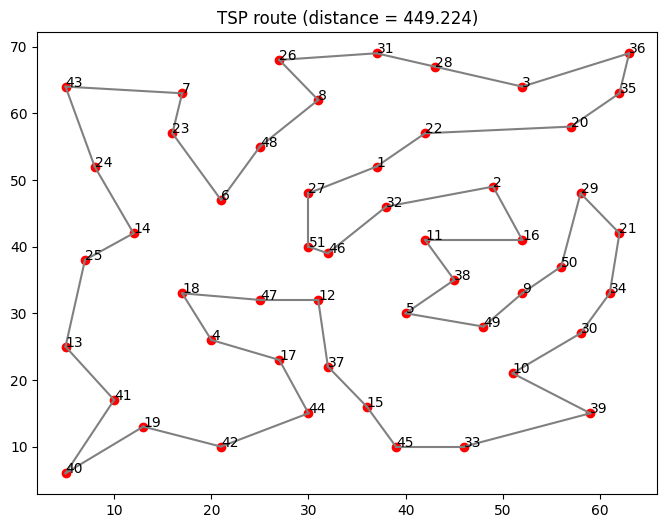

In [ ]:


# Execute the genetic algorithm
GA_tsp = GA_solver("TSP51.txt", target=450, population_size=2000)
best_route_ga, travelled_ga, best_lengths_ga, total_time_ga, iter_times_ga = GA_tsp.run()
GA_tsp.draw_map(best_route_ga)


## **IV. Compare result**

In [ ]:
import time


# Calculate total execution time for ACO and PSO
total_time_aco = sum(iter_times_aco)
total_time_pso = sum(iter_times_pso)

print("--- Algorithm Comparison ---")
print(f"Best Tour Lengths:")
print(f"  ACO: {travelled_aco}")
print(f"  PSO: {travelled_pso}")
print(f"  Genetic Algorithm: {travelled_ga}")
print("\nExecution Times (ACO and PSO):")
print(f"  ACO: {total_time_aco:.4f} seconds")
print(f"  PSO: {total_time_pso:.4f} seconds")
print(f"  GA: {total_time_ga:.4f} seconds")
print("----------------------------")

--- Algorithm Comparison ---
Best Tour Lengths:
  ACO: 469.94409150804165
  PSO: 524.5274531574562
  Genetic Algorithm: 449.2236880293385

Execution Times (ACO and PSO):
  ACO: 12.9570 seconds
  PSO: 900.9739 seconds
  GA: 30.6299 seconds
----------------------------


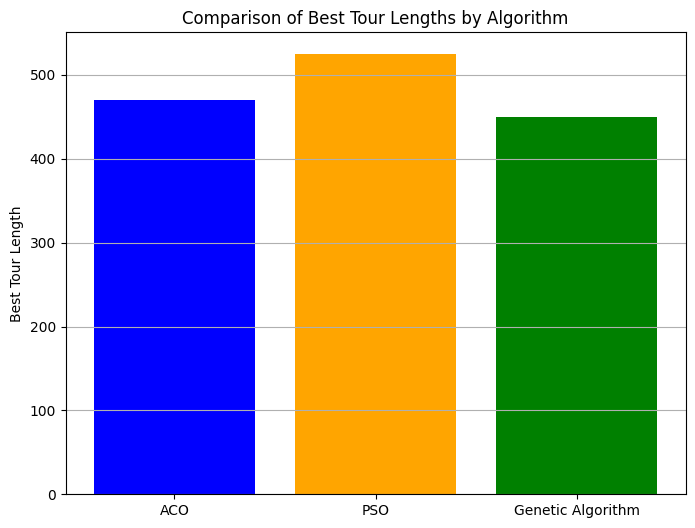

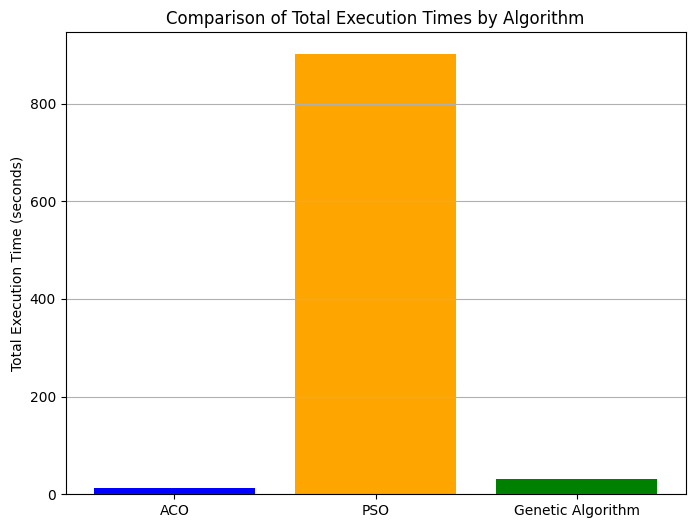

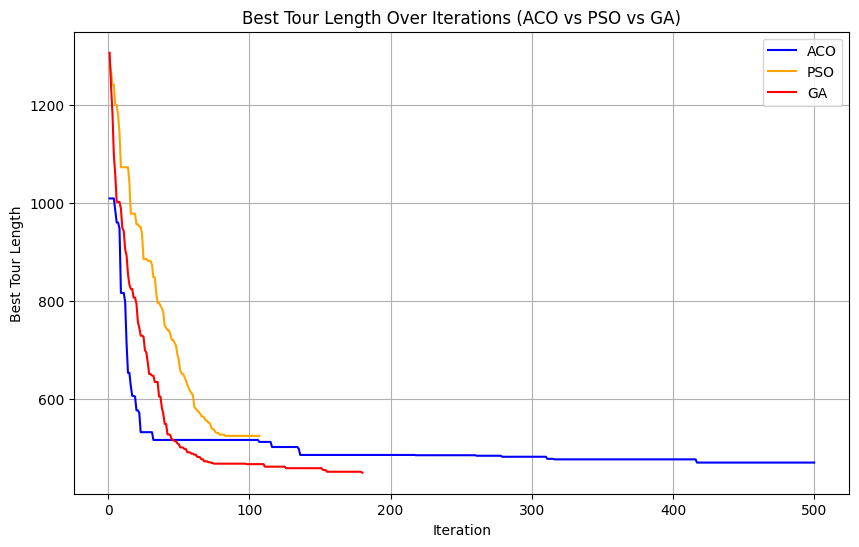

In [37]:
# 1. Bar chart comparing best tour lengths
algorithms = ['ACO', 'PSO', 'Genetic Algorithm']
best_lengths = [travelled_aco, travelled_pso, travelled_ga]

plt.figure(figsize=(8, 6))
plt.bar(algorithms, best_lengths, color=['blue', 'orange', 'green'])
plt.ylabel("Best Tour Length")
plt.title("Comparison of Best Tour Lengths by Algorithm")
plt.grid(axis='y')
plt.show()

# 2. Bar chart comparing total execution times (ACO, PSO, and GA)
algorithms_time = ['ACO', 'PSO', 'Genetic Algorithm']
total_times = [total_time_aco, total_time_pso, total_time_ga] # Include total_time_ga

plt.figure(figsize=(8, 6))
bars = plt.bar(algorithms_time, total_times, color=['blue', 'orange', 'green']) # Include green for GA
plt.ylabel("Total Execution Time (seconds)")
plt.title("Comparison of Total Execution Times by Algorithm") # Updated title
plt.grid(axis='y')

# Remove the note about GA execution time not being recorded as it's now included
# plt.text(1.5, max(total_times) * 0.9, "Note: Genetic Algorithm execution time not recorded.", horizontalalignment='center', color='red')
plt.show()

# 3. Line plots showing best tour length over iterations (ACO and PSO) - Keep as is, GA doesn't track this per iteration in current implementation
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_lengths_aco) + 1), best_lengths_aco, label='ACO', color='blue')
plt.plot(range(1, len(best_fitness_history_pso) + 1), best_fitness_history_pso, label='PSO', color='orange')
plt.plot(range(1, len(best_lengths_ga) + 1), best_lengths_ga, label='GA', color='red')
plt.xlabel("Iteration")
plt.ylabel("Best Tour Length")
plt.title("Best Tour Length Over Iterations (ACO vs PSO vs GA)")
plt.legend()
plt.grid(True)
plt.show()

## Summary:

### Data Analysis Key Findings

*   


